# mini BERT 만들기

- BERT pretrained model
 - vocab size : 8000
 - 전체 파라미터 사이즈 : 1M 
 - 학습횟수 : 10 Epoch


In [1]:
import tensorflow
import numpy
import pandas
import matplotlib
import json
import re

print(tensorflow.__version__)
print(numpy.__version__)
print(pandas.__version__)
print(matplotlib.__version__)
print(json.__version__)
print(re.__version__)

2.8.0
1.21.6
1.3.5
3.2.2
2.0.9
2.2.1


In [2]:
!mkdir 'models'
!mkdir 'data'
!unzip -qq '/content/drive/MyDrive/Colab Notebooks/Aiffel/03_GoingDeeper/14/data_234M/kowiki.txt.zip' -d './data'

In [3]:
!pip install sentencepiece

     |████████████████████████████████| 1.2 MB 12.7 MB/s 


# 1. Tokenizer 준비
- BERT의 MLM 학습용 데이터 
 - 한글 나무 위키 코퍼스로부터 8000의 vocab_size를 갖는 sentencepiece 모델
 - BERT에 사용되는 주요 특수문자가 vocab에 포함됨 : [SEP],[CLS],[MASK]









In [4]:
import sentencepiece as spm
import os
corpus_file = '/content/data/kowiki.txt'
prefix = 'ko_8000'
vocab_size = 8000

spm.SentencePieceTrainer.train(
    f"--input={corpus_file} --model_prefix={prefix} --vocab_size={vocab_size + 7}" +  # 7 : 특수토큰 + 사용자정의토큰
    " --model_type=bpe" +
    " --max_sentence_length=999999" + # 문장 최대 길이
    " --pad_id=0 --pad_piece=[PAD]" + # pad (0)
    " --unk_id=1 --unk_piece=[UNK]" + # unknown (1)
    " --bos_id=2 --bos_piece=[BOS]" + # begin of sequence (2)
    " --eos_id=3 --eos_piece=[EOS]" + # end of sequence (3)
    " --user_defined_symbols=[SEP],[CLS],[MASK]") # 사용자 정의 토큰


In [5]:
data_dir = '/content/data'
model_dir = '/content/models'

# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(f"ko_8000.model")

True

토크나이징 결과 확인

In [6]:
# 특수 token 7개를 제외한 나머지 tokens 들
vocab_list = []
for id in range(7, len(vocab)):
    if not vocab.is_unknown(id):
        vocab_list.append(vocab.id_to_piece(id))

print('vocab size:', len(vocab_list))

vocab size: 8000


In [7]:
vocab_list[:10]

['▁1', '▁이', '으로', '에서', '▁있', '▁2', '▁그', '▁대', '▁사', '이다']

# 2. 데이터 전처리 (1) MASK 생성
BERT의 MLM(Masked LM)에 필요한 빈칸(mask) 학습 데이터 
- mask_prob : 전체 토큰의 15% 정도
- 15% 학습데이터 구성
 - [MASK] 토큰 : 80% (전체의 12%)
 - 랜덤한 토큰 : 10% (전체의 1.5%)
 - 원래의 토큰 : 10% (전체의 1.5%)

- 띄어쓰기 단위로 한꺼번에 마스킹 : subword 로 나누어져있는 토큰을 단어단위로 모으는 작업
 - [ _ ]: u"\u2581" : 단어의 시작에 대한 특수 문자
 

In [8]:
# [CLS], tokens a, [SEP], tokens b, [SEP] 형태의 token 생성
string_a = "추적추적 비가 내리는 날이었어 그날은 왠지 손님이 많아 첫 번에 삼십 전 둘째번 오십 전 오랜만에 받아보는 십 전짜리 백통화 서푼에"
string_b = "손바닥 위엔 기쁨의 눈물이 흘러 컬컬한 목에 모주 한잔을 적셔 몇 달 포 전부터 콜록거리는 아내 생각에 그토록 먹고 싶다던"
tokens_org = ["[CLS]"] + vocab.encode_as_pieces(string_a) + ["[SEP]"] + vocab.encode_as_pieces(string_b) + ["[SEP]"]
print(tokens_org)

# 전체 token의 15% mask
mask_cnt = int((len(tokens_org) - 3) * 0.15)
'total token:', len(tokens_org), 'mask token:' , mask_cnt

['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]']


('total token:', 97, 'mask token:', 14)

In [9]:
# 띄어쓰기 단위로 mask하기 위해서 index 분할
cand_idx = []  # word 단위의 index array
for (i, token) in enumerate(tokens_org):
    if token == "[CLS]" or token == "[SEP]":
        continue
    if 0 < len(cand_idx) and not token.startswith(u"\u2581"):  # u"\u2581"는 단어의 시작을 의미하는 값
        cand_idx[-1].append(i)
    else:
        cand_idx.append([i])

# 결과확인
for cand in cand_idx:
    print(cand, [tokens_org[i] for i in cand])

[1, 2, 3, 4] ['▁추', '적', '추', '적']
[5, 6] ['▁비', '가']
[7, 8] ['▁내', '리는']
[9, 10, 11] ['▁날', '이었', '어']
[12, 13, 14] ['▁그', '날', '은']
[15, 16, 17] ['▁', '왠', '지']
[18, 19, 20] ['▁손', '님', '이']
[21, 22] ['▁많', '아']
[23] ['▁첫']
[24, 25] ['▁번', '에']
[26, 27] ['▁삼', '십']
[28] ['▁전']
[29, 30, 31] ['▁둘', '째', '번']
[32, 33] ['▁오', '십']
[34] ['▁전']
[35, 36, 37] ['▁오', '랜', '만에']
[38, 39, 40] ['▁받아', '보', '는']
[41] ['▁십']
[42, 43, 44] ['▁전', '짜', '리']
[45, 46, 47] ['▁백', '통', '화']
[48, 49, 50] ['▁서', '푼', '에']
[52, 53, 54] ['▁손', '바', '닥']
[55, 56] ['▁위', '엔']
[57, 58, 59] ['▁기', '쁨', '의']
[60, 61] ['▁눈', '물이']
[62, 63] ['▁흘', '러']
[64, 65, 66] ['▁컬', '컬', '한']
[67, 68] ['▁목', '에']
[69, 70] ['▁모', '주']
[71, 72, 73] ['▁한', '잔', '을']
[74, 75] ['▁적', '셔']
[76] ['▁몇']
[77] ['▁달']
[78] ['▁포']
[79, 80] ['▁전', '부터']
[81, 82, 83, 84] ['▁콜', '록', '거', '리는']
[85] ['▁아내']
[86, 87] ['▁생각', '에']
[88, 89, 90] ['▁그', '토', '록']
[91, 92] ['▁먹', '고']
[93, 94, 95] ['▁싶', '다', '던']


In [10]:
import random
import copy

# random mask를 위해서 index 순서를 섞음
random.shuffle(cand_idx)

# tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
tokens = copy.deepcopy(tokens_org)

mask_lms = []  # mask 된 값
for index_set in cand_idx:
    if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
          break
    if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
          continue
    dice = random.random()  # 0과 1 사이의 확률 값

    for index in index_set:
        masked_token = None
        if dice < 0.8:  # 80% replace with [MASK]
            masked_token = "[MASK]"
        elif dice < 0.9: # 10% keep original
            masked_token = tokens[index]
        else:  # 10% random word
            masked_token = random.choice(vocab_list)
        mask_lms.append({"index": index, "label": tokens[index]})
        tokens[index] = masked_token

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens)

tokens_org
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]'] 

tokens
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '[MASK]', '[MASK]', '[MASK]', '▁그', '날', '은', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '[MASK]', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '[MAS

### Masked LM의 라벨 데이터 생성

In [11]:
# 순서 정렬 및 mask_idx, mask_label 생성
mask_lms = sorted(mask_lms, key=lambda x: x["index"])
mask_idx = [p["index"] for p in mask_lms]
mask_label = [p["label"] for p in mask_lms]

print("mask_idx   :", mask_idx) # 15%에 해당하는 mask토큰
print("mask_label :", mask_label)

def create_pretrain_mask(tokens, mask_cnt, vocab_list):
    """
    마스크 생성
    :param tokens: tokens
    :param mask_cnt: mask 개수 (전체 tokens의 15%)
    :param vocab_list: vocab list (random token 용)
    :return tokens: mask된 tokens
    :return mask_idx: mask된 token의 index
    :return mask_label: mask된 token의 원래 값
    """
    # 단어 단위로 mask 하기 위해서 index 분할
    cand_idx = []  # word 단위의 index array
    for (i, token) in enumerate(tokens):
        if token == "[CLS]" or token == "[SEP]":
            continue
        if 0 < len(cand_idx) and not token.startswith(u"\u2581"):
            cand_idx[-1].append(i)
        else:
            cand_idx.append([i])
    # random mask를 위해서 순서를 섞음
    random.shuffle(cand_idx)

    mask_lms = []  # mask 된 값
    for index_set in cand_idx:
        if len(mask_lms) >= mask_cnt:  # 핸재 mask된 개수가 15%를 넘으면 중지
            break
        if len(mask_lms) + len(index_set) > mask_cnt:  # 이번에 mask할 개수를 포함해 15%를 넘으면 skip
            continue
        dice = random.random()  # 0..1 사이의 확률 값
        for index in index_set:
            masked_token = None
            if dice < 0.8:  # 80% replace with [MASK]
                masked_token = "[MASK]"
            elif dice < 0.9: # 10% keep original
                masked_token = tokens[index]
            else:  # 10% random word
                masked_token = random.choice(vocab_list)
            mask_lms.append({"index": index, "label": tokens[index]})
            tokens[index] = masked_token
    # mask_lms 정렬 후 mask_idx, mask_label 추출
    mask_lms = sorted(mask_lms, key=lambda x: x["index"])
    mask_idx = [p["index"] for p in mask_lms]  # mask된 token의 index
    mask_label = [p["label"] for p in mask_lms]  # mask된 token의 원래 값

    return tokens, mask_idx, mask_label

mask_idx   : [5, 6, 9, 10, 11, 15, 16, 17, 18, 19, 20, 69, 70, 77]
mask_label : ['▁비', '가', '▁날', '이었', '어', '▁', '왠', '지', '▁손', '님', '이', '▁모', '주', '▁달']


수행결과 확인해보자.

In [12]:
# tokens가 mask되므로 재 실행을 위해서 넣어줌 (테스트용)
tokens = copy.deepcopy(tokens_org)

tokens, mask_idx, mask_label = create_pretrain_mask(tokens, mask_cnt, vocab_list)

print("tokens_org")
print(tokens_org, "\n")
print("tokens")
print(tokens, "\n")

print("mask_idx   :", mask_idx)
print("mask_label :", mask_label)

tokens_org
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔', '▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '[SEP]'] 

tokens
['[CLS]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '[MASK]', '[MASK]', '[MASK]', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '▁번', '에', '[MASK]', '[MASK]', '▁전', '▁둘', '째', '번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '[MASK]', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '[SEP]', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '[MASK]', '[MASK]', '▁흘', '러', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁


# 3. 데이터 전처리 (2) NSP pair 생성
NSP 데이터 구성
- 두 문장이 연속하는지 확인하기 위해 2개의 문장을 짝지어 50%의 확률로 TRUE와 FALSE를 설정



In [13]:
string = """추적추적 비가 내리는 날이었어
그날은 왠지 손님이 많아
첫 번에 삼십 전 둘째 번 오십 전
오랜만에 받아보는 십 전짜리 백통화 서푼에
손바닥 위엔 기쁨의 눈물이 흘러
컬컬한 목에 모주 한잔을 적셔
몇 달 포 전부터 콜록거리는 아내
생각에 그토록 먹고 싶다던
설렁탕 한 그릇을 이제는 살 수 있어
집으로 돌아가는 길 난 문득 떠올라
아내의 목소리가 거칠어만 가는 희박한 숨소리가
오늘은 왠지 나가지 말라던 내 옆에 있어 달라던
그리도 나가고 싶으면 일찍이라도 들어와 달라던
아내의 간절한 목소리가 들려와
나를 원망하듯 비는 점점 거세져
싸늘히 식어가는 아내가 떠올라 걱정은 더해져
난 몰라 오늘은 운수 좋은 날
난 맨날 이렇게 살 수 있으면 얼마나 좋을까"""

# 줄 단위로 tokenize
doc = [vocab.encode_as_pieces(line) for line in string.split("\n")]
doc[:3]

[['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'],
 ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'],
 ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전']]

In [14]:
# 최대 길이
n_test_seq = 64
# 최소 길이
min_seq = 8
# [CLS], tokens_a, [SEB], tokens_b, [SEP]
max_seq = n_test_seq - 3

current_chunk = []  # line 단위 tokens
current_length = 0
for i in range(len(doc)):  # doc 전체를 loop
    current_chunk.append(doc[i])  # line 단위로 추가
    current_length += len(doc[i])  # current_chunk의 token 수
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우, 학습 데이터를 만듭니다. 
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        #######################################
        # token a
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])
        # token b
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])
          
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        #######################################
        print()

        current_chunk = []
        current_length = 0

current_chunk: 5 62 [['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'], ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'], ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전'], ['▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에'], ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']]
tokens_a: 22 ['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아']
tokens_b: 40 ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']

current_chunk: 6 71 [['▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔'], ['▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내'], ['▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던'], ['▁설', '렁', '탕', '▁한', '▁그', '릇', '을', '▁이', '제는', '

### 문장 길이 조정
 - 문장A,B가 이어져있을때 두문장의 길이가 max_seq보다 길경우 : 두문장이 이어지는것이 유지되도록 A문장은 앞쪽을 trim, B문장은 뒤쪽을 trim처리한다.

In [15]:
def trim_tokens(tokens_a, tokens_b, max_seq):
    """
    tokens_a, tokens_b의 길이를 줄임 최대 길이: max_seq
    :param tokens_a: tokens A
    :param tokens_b: tokens B
    :param max_seq: 두 tokens 길이의 최대 값
    """
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_seq:
            break

        if len(tokens_a) > len(tokens_b):
            del tokens_a[0]
        else:
            tokens_b.pop()

current_chunk = []  # line 단위 tokens
current_length = 0
for i in range(len(doc)):  # doc 전체를 loop
    current_chunk.append(doc[i])  # line 단위로 추가
    current_length += len(doc[i])  # current_chunk의 token 수
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        # token a
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])
        # token b
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])

        #######################################
        if random.random() < 0.5:  # 50% 확률로 swap
            is_next = 0     #False (뒤바뀐 문장)
            tokens_t = tokens_a
            tokens_a = tokens_b
            tokens_b = tokens_t
        else:
            is_next = 1    #True (이어지는 문장)
        # max_seq 보다 큰 경우 길이 조절
        trim_tokens(tokens_a, tokens_b, max_seq)
        assert 0 < len(tokens_a)
        assert 0 < len(tokens_b)

        print("is_next:", is_next)
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        #######################################
        print()

        current_chunk = []
        current_length = 0

current_chunk: 5 62 [['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'], ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'], ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전'], ['▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에'], ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']]
is_next: 0
tokens_a: 39 ['▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']
tokens_b: 22 ['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아']

current_chunk: 6 71 [['▁컬', '컬', '한', '▁목', '에', '▁모', '주', '▁한', '잔', '을', '▁적', '셔'], ['▁몇', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내'], ['▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던'], ['▁설', '렁', '탕', '▁한', '▁그', '릇', '을', '▁이', '제

### segmentation
- 두 문장 사이에 segment 설정
 - 첫 번째 문장 segment : 0
 - 두 번째 문장 segment : 1 
 - 두문장사이 구분자 : [SEP] 설정

In [16]:
instances = []
current_chunk = []  # line 단위 tokens
current_length = 0
for i in range(len(doc)):  # doc 전체를 loop
    current_chunk.append(doc[i])  # line 단위로 추가
    current_length += len(doc[i])  # current_chunk의 token 수
    if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):  # 마지막 줄 이거나 길이가 max_seq 이상 인 경우
        print("current_chunk:", len(current_chunk), current_length, current_chunk)

        # token a
        a_end = 1
        if 1 < len(current_chunk):
            a_end = random.randrange(1, len(current_chunk))
        tokens_a = []
        for j in range(a_end):
            tokens_a.extend(current_chunk[j])
        # token b
        tokens_b = []
        for j in range(a_end, len(current_chunk)):
            tokens_b.extend(current_chunk[j])

        if random.random() < 0.5:  # 50% 확률로 swap
            is_next = 0    # False
            tokens_t = tokens_a
            tokens_a = tokens_b
            tokens_b = tokens_t
        else:
            is_next = 1   # True
        # max_seq 보다 큰 경우 길이 조절
        trim_tokens(tokens_a, tokens_b, max_seq)
        assert 0 < len(tokens_a)
        assert 0 < len(tokens_b)

        print("is_next:", is_next)
        print("tokens_a:", len(tokens_a), tokens_a)
        print("tokens_b:", len(tokens_b), tokens_b)
        #######################################

        # tokens & segment 생성
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
        segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
        print("tokens:", len(tokens), tokens)
        print("segment:", len(segment), segment)
        
        # mask
        tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * 0.15), vocab_list)
        print("masked tokens:", len(tokens), tokens)
        print("masked index:", len(mask_idx), mask_idx)
        print("masked label:", len(mask_label), mask_label)

        instance = {
            "tokens": tokens,
            "segment": segment,
            "is_next": is_next,
            "mask_idx": mask_idx,
            "mask_label": mask_label
        }
        instances.append(instance)
        #######################################
        print()

        current_chunk = []
        current_length = 0

current_chunk: 5 62 [['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어'], ['▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아'], ['▁첫', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전'], ['▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에'], ['▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']]
is_next: 0
tokens_a: 39 ['▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러']
tokens_b: 22 ['▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아']
tokens: 64 ['[CLS]', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '▁번', '▁오', '십', '▁전', '▁오', '랜', '만에', '▁받아', '보', '는', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '[SEP]', '▁추', '적

In [17]:
# 최종 데이터셋 결과 확인
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '▁번', '에', '▁삼', '십', '▁전', '▁둘', '째', '[MASK]', '▁오', '십', '[MASK]', '▁오', '랜', '만에', '[MASK]', '[MASK]', '[MASK]', '▁십', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '[MASK]', '[MASK]', '[SEP]', '▁추', '적', '추', '적', '▁비', '가', '▁내', '리는', '▁날', '이었', '어', '▁그', '날', '은', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [8, 11, 15, 16, 17, 31, 32, 38, 39], 'mask_label': ['▁번', '▁전', '▁받아', '보', '는', '▁위', '엔', '▁흘', '러']}
{'tokens': ['[CLS]', '▁적', '셔', '[MASK]', '▁달', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '▁아내', '▁생각', '에', '▁그', '토', '록', '▁먹', '고', '▁싶', '다', '던', '▁설', '렁', '탕', '▁한', '▁그', '릇', '을', '[MASK]', '[MASK]', '▁살', '▁수', '▁있어', '[MASK]', '[MASK]', '[MASK]', '[M

### 코퍼스 생성 메소드


In [18]:
def create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list):
    """
    doc별 pretrain 데이터 생성
    """
    # for CLS], [SEP], [SEP]
    max_seq = n_seq - 3

    instances = []
    current_chunk = []
    current_length = 0
    for i in range(len(doc)):
        current_chunk.append(doc[i])  # line
        current_length += len(doc[i])
        if 1 < len(current_chunk) and (i == len(doc) - 1 or current_length >= max_seq):
            # token a
            a_end = 1
            if 1 < len(current_chunk):
                a_end = random.randrange(1, len(current_chunk))
            tokens_a = []
            for j in range(a_end):
                tokens_a.extend(current_chunk[j])
            # token b
            tokens_b = []
            for j in range(a_end, len(current_chunk)):
                tokens_b.extend(current_chunk[j])

            if random.random() < 0.5:  # 50% 확률로 swap
                is_next = 0
                tokens_t = tokens_a
                tokens_a = tokens_b
                tokens_b = tokens_t
            else:
                is_next = 1
            # max_seq 보다 큰 경우 길이 조절
            trim_tokens(tokens_a, tokens_b, max_seq)
            assert 0 < len(tokens_a)
            assert 0 < len(tokens_b)
            # tokens & aegment 생성
            tokens = ["[CLS]"] + tokens_a + ["[SEP]"] + tokens_b + ["[SEP]"]
            segment = [0] * (len(tokens_a) + 2) + [1] * (len(tokens_b) + 1)
            # mask
            tokens, mask_idx, mask_label = create_pretrain_mask(tokens, int((len(tokens) - 3) * mask_prob), vocab_list)

            instance = {
                "tokens": tokens,
                "segment": segment,
                "is_next": is_next,
                "mask_idx": mask_idx,
                "mask_label": mask_label
            }
            instances.append(instance)

            current_chunk = []
            current_length = 0
    return instances

instances = create_pretrain_instances(vocab, doc, n_test_seq, 0.15, vocab_list)

# 최종 데이터셋 결과 확인
for instance in instances:
    print(instance)

{'tokens': ['[CLS]', '▁오', '랜', '만에', '▁받아', '보', '는', '[MASK]', '▁전', '짜', '리', '▁백', '통', '화', '▁서', '푼', '에', '▁손', '바', '닥', '▁위', '엔', '▁기', '쁨', '의', '▁눈', '물이', '▁흘', '러', '[SEP]', '▁추', '적', '추', '적', '▁계속', '떡', '▁내', '리는', '▁날', '이었', '어', '[MASK]', '[MASK]', '[MASK]', '▁', '왠', '지', '▁손', '님', '이', '▁많', '아', '▁첫', '[MASK]', '[MASK]', '▁삼', '십', '▁전', '▁둘', '째', '[MASK]', '▁오', '십', '[SEP]'], 'segment': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'is_next': 0, 'mask_idx': [7, 34, 35, 41, 42, 43, 53, 54, 60], 'mask_label': ['▁십', '▁비', '가', '▁그', '날', '은', '▁번', '에', '▁번']}
{'tokens': ['[CLS]', '▁아내', '의', '▁목', '소', '리가', '▁거', '칠', '어', '만', '▁가는', '▁희', '박', '한', '▁숨', '소', '리가', '[SEP]', '▁컬', '컬', '한', '▁목', '에', '▁모', '주', '[MASK]', '[MASK]', '[MASK]', '▁적', '셔', '▁몇', '[MASK]', '▁포', '▁전', '부터', '▁콜', '록', '거', '리는', '[MA

# 4. 데이터 전처리 (3) 데이터셋 완성
- make_pretrain_data 함수
 - BERT pretrain 데이터셋을 생성 
 - json 포맷으로 저장(bert_pre_train.json)

- load_pre_train_data 함수
 - 학습에 필요한 데이터를 로딩하는 함수
 - np.memmap을 사용해 메모리 사용량을 최소화하여 로딩


In [19]:
from tqdm.notebook import tqdm
import numpy as np

corpus_file = '/content/data/kowiki.txt'

def make_pretrain_data(vocab, in_file, out_file, n_seq, mask_prob=0.15):
    """ pretrain 데이터 생성 """
    def save_pretrain_instances(out_f, doc):
        instances = create_pretrain_instances(vocab, doc, n_seq, mask_prob, vocab_list)
        for instance in instances:
            out_f.write(json.dumps(instance, ensure_ascii=False))
            out_f.write("\n")

    # 특수문자 7개를 제외한 vocab_list 생성
    vocab_list = []
    for id in range(7, len(vocab)):
        if not vocab.is_unknown(id):        # 생성되는 단어 목록이 unknown인 경우는 제거합니다. 
            vocab_list.append(vocab.id_to_piece(id))

    # line count 확인
    line_cnt = 0
    with open(in_file, "r") as in_f:
        for line in in_f:
            line_cnt += 1

    with open(in_file, "r") as in_f:
        with open(out_file, "w") as out_f:
            doc = []
            for line in tqdm(in_f, total=line_cnt):
                line = line.strip()
                if line == "":  # line이 빈줄 일 경우 (새로운 단락)
                    if 0 < len(doc):
                        save_pretrain_instances(out_f, doc)
                        doc = []
                else:  # line이 빈줄이 아닐 경우 tokenize 해서 doc에 저장
                    pieces = vocab.encode_as_pieces(line)
                    if 0 < len(pieces):
                        doc.append(pieces)
            if 0 < len(doc):  # 마지막에 처리되지 않은 doc가 있는 경우
                save_pretrain_instances(out_f, doc)
                doc = []

pretrain_json_path = 'data/bert_pre_train.json'

make_pretrain_data(vocab, corpus_file, pretrain_json_path, 128)

  0%|          | 0/3957761 [00:00<?, ?it/s]

In [20]:
def load_pre_train_data(vocab, filename, n_seq, count=None):
    """
    학습에 필요한 데이터를 로드
    :param vocab: vocab
    :param filename: 전처리된 json 파일
    :param n_seq: 시퀀스 길이 (number of sequence)
    :param count: 데이터 수 제한 (None이면 전체)
    :return enc_tokens: encoder inputs
    :return segments: segment inputs
    :return labels_nsp: nsp labels
    :return labels_mlm: mlm labels
    """
    total = 0
    with open(filename, "r") as f:
        for line in f:
            total += 1
            # 데이터 수 제한
            if count is not None and count <= total:
                break
    
    # np.memmap을 사용하면 메모리를 적은 메모리에서도 대용량 데이터 처리가 가능 함
    enc_tokens = np.memmap(filename='enc_tokens.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    segments = np.memmap(filename='segments.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))
    labels_nsp = np.memmap(filename='labels_nsp.memmap', mode='w+', dtype=np.int32, shape=(total,))
    labels_mlm = np.memmap(filename='labels_mlm.memmap', mode='w+', dtype=np.int32, shape=(total, n_seq))

    with open(filename, "r") as f:
        for i, line in enumerate(tqdm(f, total=total)):
            if total <= i:
                print("data load early stop", total, i)
                break
            data = json.loads(line)
            # encoder token
            enc_token = [vocab.piece_to_id(p) for p in data["tokens"]]
            enc_token += [0] * (n_seq - len(enc_token))
            # segment
            segment = data["segment"]
            segment += [0] * (n_seq - len(segment))
            # nsp label
            label_nsp = data["is_next"]
            # mlm label
            mask_idx = np.array(data["mask_idx"], dtype=np.int)
            mask_label = np.array([vocab.piece_to_id(p) for p in data["mask_label"]], dtype=np.int)
            label_mlm = np.full(n_seq, dtype=np.int, fill_value=0)
            label_mlm[mask_idx] = mask_label

            assert len(enc_token) == len(segment) == len(label_mlm) == n_seq

            enc_tokens[i] = enc_token
            segments[i] = segment
            labels_nsp[i] = label_nsp
            labels_mlm[i] = label_mlm

    return (enc_tokens, segments), (labels_nsp, labels_mlm)

In [21]:
# 128000건만 메모리에 로딩
pre_train_inputs, pre_train_labels = load_pre_train_data(vocab, pretrain_json_path, 128, count=128000)

# 처음과 마지막 확인
pre_train_inputs[0][0], pre_train_inputs[0][-1], pre_train_inputs[1][0], pre_train_inputs[1][-1], pre_train_labels[0][0], pre_train_labels[0][-1], pre_train_labels[1][0], pre_train_labels[1][-1]

  0%|          | 0/128000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:42: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecat

data load early stop 128000 128000


(memmap([   5,    6, 1605, 3599, 1755, 3630,   41, 3644,  830, 3624,    6,
            6,    6,   13,   81,   87, 1501,    6,   25, 3779, 3873, 3667,
         3631, 3813, 3873, 4196, 3636, 3779, 3601,  249, 3725, 1232,   33,
           52, 3599,  479, 3652, 3625,  243, 2780,   14, 1509,    6,    6,
            6,  165, 1697, 4290, 3873, 3703, 3683,    6,   21, 5007,    6,
         1927, 3607,  813,   17, 3599, 3746,  587,  931,  103, 4313, 4290,
          613, 3638, 3718,   98, 3878, 3656,  256, 2543,  309,  337, 3735,
          181, 3616, 3603,    6,    6,    6,    4,   18, 3686,  207, 3714,
         3324, 1042,  103, 3610, 3686, 3718,  207, 3714,   37, 3418,  416,
          810, 3666, 3625,  131, 3662,    7, 3629,  203,  241, 3602, 1114,
         3724,  788,    6,   49, 3632,  796,  663, 1647, 3682, 3682, 3625,
          203, 3008, 3625, 3616,   16, 3599,    4], dtype=int32),
 memmap([   5,   13,   81, 3604,    6,    6, 6313, 3562, 4500,    6,  316,
         1425,  173,  305, 3620, 1

# 5. BERT 모델 구현


Embedding 레이어, Transformer encoder 레이어, BERT 레이어를 구성한 후, pretraine용 BERT 모델을 만들어 봅시다.


### 유틸리티 함수
- pad mask 함수
- ahead mask 함수
- gelu activation 함수
- parameter initializer 생성 함수, 
- json을 config 형태설정 함수

In [22]:
import tensorflow as tf
import tensorflow.keras.backend as K

def get_pad_mask(tokens, i_pad=0):
    """
    pad mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: pad mask (pad: 1, other: 0)
    """
    mask = tf.cast(tf.math.equal(tokens, i_pad), tf.float32)
    mask = tf.expand_dims(mask, axis=1)
    return mask


def get_ahead_mask(tokens, i_pad=0):
    """
    ahead mask 계산하는 함수
    :param tokens: tokens (bs, n_seq)
    :param i_pad: id of pad
    :return mask: ahead and pad mask (ahead or pad: 1, other: 0)
    """
    n_seq = tf.shape(tokens)[1]
    ahead_mask = 1 - tf.linalg.band_part(tf.ones((n_seq, n_seq)), -1, 0)
    ahead_mask = tf.expand_dims(ahead_mask, axis=0)
    pad_mask = get_pad_mask(tokens, i_pad)
    mask = tf.maximum(ahead_mask, pad_mask)
    return mask


@tf.function(experimental_relax_shapes=True)
def gelu(x):
    """
    gelu activation 함수
    :param x: 입력 값
    :return: gelu activation result
    """
    return 0.5*x*(1+tf.tanh(np.sqrt(2/np.pi)*(x+0.044715*tf.pow(x, 3))))

def kernel_initializer(stddev=0.02):
    """
    parameter initializer 생성
    :param stddev: 생성할 랜덤 변수의 표준편차
    """
    return tf.keras.initializers.TruncatedNormal(stddev=stddev)


def bias_initializer():
    """
    bias initializer 생성
    """
    return tf.zeros_initializer


class Config(dict):
    """
    json을 config 형태로 사용하기 위한 Class
    :param dict: config dictionary
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__

    @classmethod
    def load(cls, file):
        """
        file에서 Config를 생성 함
        :param file: filename
        """
        with open(file, 'r') as f:
            config = json.loads(f.read())
            return Config(config)

### embedding 레이어
- Token Embedding
- Segment Embedding
- Position Embedding : 별도의 레이어를 구현하지 않고 BERT 클래스에서 간단히 포함

In [23]:
class SharedEmbedding(tf.keras.layers.Layer):
    """
    Weighed Shaed Embedding Class
    """
    def __init__(self, config, name="weight_shared_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.n_vocab = config.n_vocab
        self.d_model = config.d_model
    
    def build(self, input_shape):
        """
        shared weight 생성
        :param input_shape: Tensor Shape (not used)
        """
        with tf.name_scope("shared_embedding_weight"):
            self.shared_weights = self.add_weight(
                "weights",
                shape=[self.n_vocab, self.d_model],
                initializer=kernel_initializer()
            )

    def call(self, inputs, mode="embedding"):
        """
        layer 실행
        :param inputs: 입력
        :param mode: 실행 모드
        :return: embedding or linear 실행 결과
        """
        # mode가 embedding일 경우 embedding lookup 실행
        if mode == "embedding":
            return self._embedding(inputs)
        # mode가 linear일 경우 linear 실행
        elif mode == "linear":
            return self._linear(inputs)
        # mode가 기타일 경우 오류 발생
        else:
            raise ValueError(f"mode {mode} is not valid.")
    
    def _embedding(self, inputs):
        """
        embedding lookup
        :param inputs: 입력
        """
        embed = tf.gather(self.shared_weights, tf.cast(inputs, tf.int32))
        return embed

    def _linear(self, inputs):  # (bs, n_seq, d_model)
        """
        linear 실행
        :param inputs: 입력
        """
        n_batch = tf.shape(inputs)[0]
        n_seq = tf.shape(inputs)[1]
        inputs = tf.reshape(inputs, [-1, self.d_model])  # (bs * n_seq, d_model)
        outputs = tf.matmul(inputs, self.shared_weights, transpose_b=True)
        outputs = tf.reshape(outputs, [n_batch, n_seq, self.n_vocab])  # (bs, n_seq, n_vocab)
        return outputs


class PositionEmbedding(tf.keras.layers.Layer):
    """
    Position Embedding Class
    """
    def __init__(self, config, name="position_embedding"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)
        
        self.embedding = tf.keras.layers.Embedding(config.n_seq, config.d_model, embeddings_initializer=kernel_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: 입력
        :return embed: position embedding lookup 결과
        """
        position = tf.cast(tf.math.cumsum(tf.ones_like(inputs), axis=1, exclusive=True), tf.int32)
        embed = self.embedding(position)
        return embed
print("슝=3")

슝=3


### Attention
 - ScaleDotProductAttention
 - MultiHeadAttention

In [24]:
class ScaleDotProductAttention(tf.keras.layers.Layer):
    """
    Scale Dot Product Attention Class
    """
    def __init__(self, name="scale_dot_product_attention"):
        """
        생성자
        :param name: layer name
        """
        super().__init__(name=name)

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        attn_score = tf.matmul(Q, K, transpose_b=True)
        scale = tf.math.sqrt(tf.cast(tf.shape(K)[-1], tf.float32))
        attn_scale = tf.math.divide(attn_score, scale)
        attn_scale -= 1.e9 * attn_mask
        attn_prob = tf.nn.softmax(attn_scale, axis=-1)
        attn_out = tf.matmul(attn_prob, V)
        return attn_out

class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Multi Head Attention Class
    """
    def __init__(self, config, name="multi_head_attention"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.d_model = config.d_model
        self.n_head = config.n_head
        self.d_head = config.d_head

        # Q, K, V input dense layer
        self.W_Q = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_K = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_V = tf.keras.layers.Dense(config.n_head * config.d_head, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        # Scale Dot Product Attention class
        self.attention = ScaleDotProductAttention(name="self_attention")
        # output dense layer
        self.W_O = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, Q, K, V, attn_mask):
        """
        layer 실행
        :param Q: Q value
        :param K: K value
        :param V: V value
        :param attn_mask: 실행 모드
        :return attn_out: attention 실행 결과
        """
        # reshape Q, K, V, attn_mask
        batch_size = tf.shape(Q)[0]
        Q_m = tf.transpose(tf.reshape(self.W_Q(Q), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, Q_len, d_head)
        K_m = tf.transpose(tf.reshape(self.W_K(K), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        V_m = tf.transpose(tf.reshape(self.W_V(V), [batch_size, -1, self.n_head, self.d_head]), [0, 2, 1, 3])  # (bs, n_head, K_len, d_head)
        attn_mask_m = tf.expand_dims(attn_mask, axis=1)
        # Scale Dot Product Attention with multi head Q, K, V, attn_mask
        attn_out = self.attention(Q_m, K_m, V_m, attn_mask_m)  # (bs, n_head, Q_len, d_head)
        # transpose and liner
        attn_out_m = tf.transpose(attn_out, perm=[0, 2, 1, 3])  # (bs, Q_len, n_head, d_head)
        attn_out = tf.reshape(attn_out_m, [batch_size, -1, config.n_head * config.d_head])  # (bs, Q_len, d_model)
        attn_out = self.W_O(attn_out) # (bs, Q_len, d_model)

        return attn_out


- FeedForward 레이어
- transformer encoder 레이어
- BERT 레이어

In [25]:
class PositionWiseFeedForward(tf.keras.layers.Layer):
    """
    Position Wise Feed Forward Class
    """
    def __init__(self, config, name="feed_forward"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.W_1 = tf.keras.layers.Dense(config.d_ff, activation=gelu, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.W_2 = tf.keras.layers.Dense(config.d_model, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())

    def call(self, inputs):
        """
        layer 실행
        :param inputs: inputs
        :return ff_val: feed forward 실행 결과
        """
        ff_val = self.W_2(self.W_1(inputs))
        return ff_val

class EncoderLayer(tf.keras.layers.Layer):
    """
    Encoder Layer Class
    """
    def __init__(self, config, name="encoder_layer"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.self_attention = MultiHeadAttention(config)
        self.norm1 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.ffn = PositionWiseFeedForward(config)
        self.norm2 = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)

        self.dropout = tf.keras.layers.Dropout(config.dropout)
 
    def call(self, enc_embed, self_mask):
        """
        layer 실행
        :param enc_embed: enc_embed 또는 이전 EncoderLayer의 출력
        :param self_mask: enc_tokens의 pad mask
        :return enc_out: EncoderLayer 실행 결과
        """
        self_attn_val = self.self_attention(enc_embed, enc_embed, enc_embed, self_mask)
        norm1_val = self.norm1(enc_embed + self.dropout(self_attn_val))

        ffn_val = self.ffn(norm1_val)
        enc_out = self.norm2(norm1_val + self.dropout(ffn_val))

        return enc_out


class BERT(tf.keras.layers.Layer):
    """
    BERT Class
    """
    def __init__(self, config, name="bert"):
        """
        생성자
        :param config: Config 객체
        :param name: layer name
        """
        super().__init__(name=name)

        self.i_pad = config.i_pad
        self.embedding = SharedEmbedding(config)
        self.position = PositionEmbedding(config)
        self.segment = tf.keras.layers.Embedding(2, config.d_model, embeddings_initializer=kernel_initializer())
        self.norm = tf.keras.layers.LayerNormalization(epsilon=config.layernorm_epsilon)
        
        self.encoder_layers = [EncoderLayer(config, name=f"encoder_layer_{i}") for i in range(config.n_layer)]

        self.dropout = tf.keras.layers.Dropout(config.dropout)

    def call(self, inputs):
        """
        layer 실행
        :param inputs: (enc_tokens, segments)
        :return logits: dec_tokens에 대한 다음 토큰 예측 결과 logits
        """
        enc_tokens, segments = inputs

        enc_self_mask = tf.keras.layers.Lambda(get_pad_mask, output_shape=(1, None), name='enc_self_mask')(enc_tokens, self.i_pad)

        enc_embed = self.get_embedding(enc_tokens, segments)

        enc_out = self.dropout(enc_embed)
        for encoder_layer in self.encoder_layers:
            enc_out = encoder_layer(enc_out, enc_self_mask)

        logits_cls = enc_out[:,0]
        logits_lm = self.embedding(enc_out, mode="linear")
        return logits_cls, logits_lm
    
    def get_embedding(self, tokens, segments):
        """
        token embedding, position embedding lookup
        :param tokens: 입력 tokens
        :param segments: 입력 segments
        :return embed: embedding 결과
        """
        embed = self.embedding(tokens) + self.position(tokens) + self.segment(segments)
        embed = self.norm(embed)
        return embed


아주 작은 pretrain용 BERT 모델(test_model)을 생성하여 동작을 미리 확인해보겠다.

In [26]:
# Encoder Layer class 정의
class PooledOutput(tf.keras.layers.Layer):
    def __init__(self, config, n_output, name="pooled_output"):
        super().__init__(name=name)

        self.dense1 = tf.keras.layers.Dense(config.d_model, activation=tf.nn.tanh, kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
        self.dense2 = tf.keras.layers.Dense(n_output, use_bias=False, activation=tf.nn.softmax, name="nsp", kernel_initializer=kernel_initializer(), bias_initializer=bias_initializer())
 
    def call(self, inputs):
        outputs = self.dense1(inputs)
        outputs = self.dense2(outputs)
        return outputs


def build_model_pre_train(config):
    enc_tokens = tf.keras.layers.Input((None,), name="enc_tokens")
    segments = tf.keras.layers.Input((None,), name="segments")

    bert = BERT(config)
    logits_cls, logits_lm = bert((enc_tokens, segments))

    logits_cls = PooledOutput(config, 2, name="pooled_nsp")(logits_cls)
    outputs_nsp = tf.keras.layers.Softmax(name="nsp")(logits_cls)

    outputs_mlm = tf.keras.layers.Softmax(name="mlm")(logits_lm)

    model = tf.keras.Model(inputs=(enc_tokens, segments), outputs=(outputs_nsp, outputs_mlm))
    return model


# 6. pretrain 진행



### loss, accuracy 함수

In [29]:
def lm_loss(y_true, y_pred):
    """
    loss 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # loss 계산
    loss = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=loss.dtype)
    loss *= mask
    return loss * 20  # mlm을 더 잘 학습하도록 20배 증가 시킴

def lm_acc(y_true, y_pred):
    """
    acc 계산 함수
    :param y_true: 정답 (bs, n_seq)
    :param y_pred: 예측 값 (bs, n_seq, n_vocab)
    """
    # 정답 여부 확인
    y_pred_class = tf.cast(K.argmax(y_pred, axis=-1), tf.float32)
    matches = tf.cast(K.equal(y_true, y_pred_class), tf.float32)
    # pad(0) 인 부분 mask
    mask = tf.cast(tf.math.not_equal(y_true, 0), dtype=matches.dtype)
    matches *= mask
    # 정확도 계산
    accuracy = K.sum(matches) / K.maximum(K.sum(mask), 1)
    return accuracy


### Learning Rate 스케줄링
- WarmUp 이후 consine 형태로 감소하는 스케줄

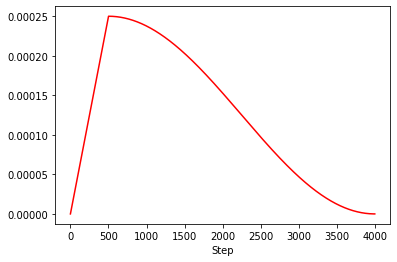

In [30]:
import math
import matplotlib.pyplot as plt

class CosineSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    CosineSchedule Class
    """
    def __init__(self, train_steps=4000, warmup_steps=2000, max_lr=2.5e-4):
        """
        생성자
        :param train_steps: 학습 step 총 합
        :param warmup_steps: warmup steps
        :param max_lr: 최대 learning rate
        """
        super().__init__()

        assert 0 < warmup_steps < train_steps
        self.warmup_steps = warmup_steps
        self.train_steps = train_steps
        self.max_lr = max_lr

    def __call__(self, step_num):
        """
        learning rate 계산
        :param step_num: 현재 step number
        :retrun: 계산된 learning rate
        """
        state = tf.cast(step_num <= self.warmup_steps, tf.float32)
        lr1 = tf.cast(step_num, tf.float32) / self.warmup_steps
        progress = tf.cast(step_num - self.warmup_steps, tf.float32) / max(1, self.train_steps - self.warmup_steps)
        lr2 = 0.5 * (1.0 + tf.math.cos(math.pi * progress))
        return (state * lr1 + (1 - state) * lr2) * self.max_lr

# compute lr 
test_schedule = CosineSchedule(train_steps=4000, warmup_steps=500)
lrs = []
for step_num in range(4000):
    lrs.append(test_schedule(float(step_num)).numpy())

# draw
plt.plot(lrs, 'r-', label='learning_rate')
plt.xlabel('Step')
plt.show()

### 모델 생성


파라미터 사이즈 : 약 1M (1,025,080)개

- batch_size : 32

In [59]:
config = Config({"d_model": 100, "n_head": 4, "d_head": 32, "dropout": 0.1, "d_ff": 256, 
                 "layernorm_epsilon": 0.001, "n_layer": 2, "n_seq": 64, "n_vocab": 0, "i_pad": 0})

config.n_vocab = len(vocab)
config.i_pad = vocab.pad_id()

pre_train_model = build_model_pre_train(config)
pre_train_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_tokens (InputLayer)        [(None, None)]       0           []                               
                                                                                                  
 segments (InputLayer)          [(None, None)]       0           []                               
                                                                                                  
 bert (BERT)                    ((None, 100),        1014780     ['enc_tokens[0][0]',             
                                 (None, None, 8007)               'segments[0][0]']               
                                )                                                                 
                                                                                           

In [60]:
epochs = 10
batch_size = 32 

# optimizer
train_steps = math.ceil(len(pre_train_inputs[0]) / batch_size) * epochs
print("train_steps:", train_steps)
learning_rate = CosineSchedule(train_steps=train_steps, warmup_steps=max(100, train_steps // 10))
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# compile
pre_train_model.compile(loss=(tf.keras.losses.sparse_categorical_crossentropy, lm_loss), optimizer=optimizer, metrics={"nsp": "acc", "mlm": lm_acc})

train_steps: 40000


In [56]:
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(f"{model_dir}/bert_pre_train.hdf5", monitor="mlm_lm_acc", verbose=1, save_best_only=True, mode="max", save_freq="epoch", save_weights_only=True)
# train
history = pre_train_model.fit(pre_train_inputs, pre_train_labels, epochs=epochs, batch_size=batch_size, callbacks=[save_weights])

Epoch 1/10
3999/4000 [============================>.] - ETA: 0s - loss: 16.9385 - nsp_loss: 0.6007 - mlm_loss: 16.3378 - nsp_acc: 0.6648 - mlm_lm_acc: 0.1326
Epoch 1: mlm_lm_acc improved from -inf to 0.13260, saving model to /content/models/bert_pre_train.hdf5
4000/4000 [==============================] - 146s 36ms/step - loss: 16.9382 - nsp_loss: 0.6007 - mlm_loss: 16.3376 - nsp_acc: 0.6648 - mlm_lm_acc: 0.1326
Epoch 2/10
3999/4000 [============================>.] - ETA: 0s - loss: 16.8944 - nsp_loss: 0.6067 - mlm_loss: 16.2877 - nsp_acc: 0.6540 - mlm_lm_acc: 0.1333
Epoch 2: mlm_lm_acc improved from 0.13260 to 0.13333, saving model to /content/models/bert_pre_train.hdf5
4000/4000 [==============================] - 144s 36ms/step - loss: 16.8944 - nsp_loss: 0.6067 - mlm_loss: 16.2877 - nsp_acc: 0.6540 - mlm_lm_acc: 0.1333
Epoch 3/10
3999/4000 [============================>.] - ETA: 0s - loss: 16.6938 - nsp_loss: 0.6060 - mlm_loss: 16.0877 - nsp_acc: 0.6556 - mlm_lm_acc: 0.1357
Epoch 3: 

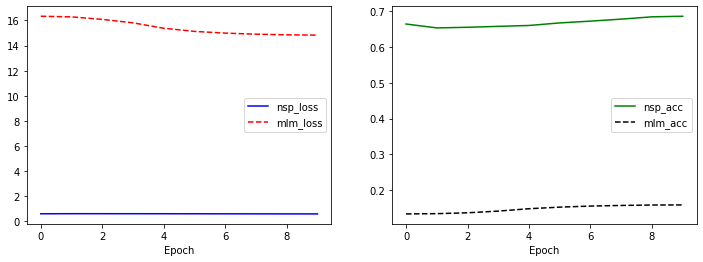

In [58]:
# training result
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['nsp_loss'], 'b-', label='nsp_loss')
plt.plot(history.history['mlm_loss'], 'r--', label='mlm_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['nsp_acc'], 'g-', label='nsp_acc')
plt.plot(history.history['mlm_lm_acc'], 'k--', label='mlm_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

---
## 정리.


**mini Bert 모델 성능 비교**

| 학습시 설정 사항 |10M 모델	| 1M 모델(v4_최종)| 1M 모델(v1)| 
|---|---|---| ---|
|에폭 | 10회  | 10회 |10회 |
| 모델 파라미터| 약 천만개( 10,695,936) | **약 백만개(1,025,080)** |약 125만개(1,249,536) |
| 배치사이즈| 64 |**32**  |64|
| n_vocab| 32007| 8007|8007|
|d_ff | 1024|256|1024|
| d_head| 64|32|64|
| d_model|256 |**100**|64|
| n_head| 4|4|4|
| n_layer| 3|2|3|
| n_seq|256 |64|256|
|---|---|---|---|
|loss | 13.76|15.43|16.94|
|nsp_loss | 0.44|0.58|0.60|
|mlm_loss | 13.32|14.84|16.34|
| nsp_acc|0.87 |0.68|0.66|
| mlm_lm_acc|0.24 |0.16|0.13|


- 이전 LMS 노드에서 만들었던 10M Bert모델의 경우 파라미터 튜닝없이  설정된 대로 학습을 진행한 결과이다.
-  학습 파라미터가 5M개 정도일때 기존 성능보다 loss가 12이하로 줄기도 하지만 본 프로젝트에서는 1M로 모델 파라미터를 줄인 bert모델로 성능을 확인해보았다. config의 파라미터를 튜닝해 로스와 정확도를 비슷한 수준으로 만들기위해 파라미터 튜닝을 진행하였다.
 - 파라미터를 10배로 줄여서인지 로스를 크게 줄이긴 어려웠지만 파라미터 튜닝으로 loss및 정확도에서 유의미한 성능 향상을 가져올수 있었다.
 